# Part 1 - Exploratory Data Analysis (EDA)

We will start with an Exploratory Data Analysis (EDA) of our SF housing dataset.  
It is always a good idea to start with an EDA before designing and training a machine learning algorithm.  
EDA gives us better insight to the data by using statistical and visualization techniques.  
Most of these EDA techniques were adopted from various [Kaggle] kernels.  

Upon completing this notebook, we should have:  
* Familiarity with [Pandas] and [NumPy] for data management and analysis
* Familiarity with [Matplotlib] and [seaborn] for visualization
* A decent understanding of the characteristics of our dataset
[Pandas]: https://pandas.pydata.org/
[NumPy]: http://www.numpy.org/
[Matplotlib]: https://matplotlib.org/
[seaborn]: https://seaborn.pydata.org/
[Kaggle]: https://www.kaggle.com/

In [132]:
# some python libs are missing if using Colab
!pip install geopy geojson folium branca

tb-nightly 1.8.0a20180424 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
bleach 2.1.3 has requirement html5lib!=1.0b1,!=1.0b2,!=1.0b3,!=1.0b4,!=1.0b5,!=1.0b6,!=1.0b7,!=1.0b8,>=0.99999999pre, but you'll have html5lib 0.9999999 which is incompatible.


In [133]:
import glob
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap

%matplotlib inline

## Let's start by loading the data and have a peek at the contents 
The data was scraped from [zillow.com](https://www.zillow.com/) and is dispersed between several csv files.  
We will use Pandas to load the csv files and concatenate them into a single DataFrame

In [134]:
import os
import zipfile
import urllib.request
import pandas as pd

def download_extract_data(data_dir: str):

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    data_save_path = os.path.join(data_dir, 'data.zip')
    data_download_url = 'https://github.com/kylehounslow/mlbootcamp/raw/master/data/sf_housing.zip'

    print('downloading data...')
    urllib.request.urlretrieve(data_download_url, data_save_path)
    print('extracting data...')
    data_zip = zipfile.ZipFile(data_save_path)
    data_zip.extractall(data_dir)
    data_zip.close()

def load_data_to_dataframe(data_dir: str) -> pd.DataFrame:
    all_csvs = []
    # load the csv files from all scraping runs
    csv_filenames = os.path.join(data_dir, '**/*.csv')
    print(f'loading data {csv_filenames}')
    for filename in glob.glob(csv_filenames):
        all_csvs.append(pd.read_csv(filename))
    # combine all dataframes together and drop any duplicate entries
    df = pd.concat(all_csvs, ignore_index=True).drop_duplicates()
    print(f"Found a total of {len(df)} data points")
    # save this combined dataframe as csv for safe keeping
    df.to_csv(os.path.join(data_dir, 'data_raw.csv'), index=False)
    return df

In [135]:
data_dir = './data'  # download and extract data here
download_extract_data(data_dir=data_dir)
df_raw = load_data_to_dataframe(data_dir=data_dir)
df_raw.head(5)  # display first 5 entries

downloading data...
extracting data...
loading data ./data/**/*.csv
Found a total of 1262 data points


,title,address,city,state,postal_code,price,facts and features,real estate provider,url
0,New Construction,288 Pacific Ave # 67UQRR,San Francisco,CA,94111,NaN,"-- bds , -- ba , -- sqft",NaN,https://www.zillow.com/community/288-pacific/2...
1,Condo For Sale,733 Front St UNIT 606,SAN FRANCISCO,CA,94111,"$1,195,000","1 bd , 1 ba , 920 sqft",Climb Real Estate,https://www.zillow.com/homedetails/733-Front-S...
2,Condo For Sale,101 Lombard St APT 401W,SAN FRANCISCO,CA,94111,"$1,425,000","2 bds , 2 ba , 1,238 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/101-Lombard...
3,Condo For Sale,111 Chestnut St UNIT 109,SAN FRANCISCO,CA,94111,"$1,600,000","2 bds , 2 ba , 1,925 sqft",CENTURY 21 Real Estate Alliance,https://www.zillow.com/homedetails/111-Chestnu...
4,Lot/Land For Sale,1235 Sansome St,San Francisco,CA,94111,"$998,000","6,882 sqft lot",NaN,https://www.zillow.com/homedetails/1235-Sansom...


### Our data is now contained in a variable named `df_raw` which is a pandas DataFrame.

## Display some quick stats about the DataFrame
DataFrame has a few built in functions we can call to get a quick summary of the data:  
* `info()` displays a count of all non-null objects and their datatypes  
* `describe()` calculates basic statistics about all numerical values in the DataFrame

In [136]:
df_raw.info()
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1262 entries, 0 to 2413
Data columns (total 9 columns):
title                   1262 non-null object
address                 1262 non-null object
city                    1262 non-null object
state                   1262 non-null object
postal_code             1262 non-null object
price                   1260 non-null object
facts and features      1262 non-null object
real estate provider    986 non-null object
url                     1262 non-null object
dtypes: object(9)
memory usage: 98.6+ KB


,title,address,city,state,postal_code,price,facts and features,real estate provider,url
count,1262,1262,1262,1262,1262,1260,1262,986,1262
unique,11,1197,9,1,33,557,1028,199,1200
top,Condo For Sale,1214 Masonic Ave,San Francisco,CA,94109,"$1,495,000","2 bds , 1 ba , -- sqft",Zephyr Real Estate,https://www.zillow.com/homedetails/479-Los-Pal...
freq,559,3,863,1262,83,31,14,98,3


Our `describe()` method does not yet have any numerical data to describe for us.

Notice that a lot of the columns which provide numerical data are not in a format ready for consumption.  
For instance the `price` columns contain `$` and `,` characters and the `facts and features` column has valuable information about number of beds, bath and square footage embedded within the text.  
  
Let's parse and format these columns.

In [137]:
# copy our original dataframe for safe keeping. We will manipulate `df` instead
df = df_raw.copy()

## Reformat price column
Time to use some convenient Pandas functions such as `.apply()` to apply a user defined formatting function to all values in a column.  

Remove `$` and `,` characters and format as `int`.  
Also, some prices are represented as `$1K` and `$1M` so let's replace with `1000` and `1000000`

In [138]:
import re
def format_price(price):
    """Remove all non-numerical"""
    price = str(price)
    multiply_factor = 1
    if 'M' in price:
        multiply_factor = 1e6
    elif 'K' in price:
        multiply_factor = 1e3
    non_decimal = re.compile(r'[^0-9\.]')
    price_num = None
    try:
        price_num = float(non_decimal.sub('', price))*multiply_factor
    except Exception as e:
#         print(f'error converting \"{price}\": {e}')
        pass
    finally:
        return price_num

# replace the values in the price column with the formatted price
df['price'] = df.price.apply(format_price)

## Parse `facts and features` column into multiple columns 
An example entry in this column: `3 bds , 2 ba , 1,520 sqft`  
Parse the text using comma followed by a space '`, `' as the delimiter so that we can still capture the comma in the square footage.

In [140]:
# TODO: consider studio as 0 beds?
non_decimal = re.compile(r'[^\d.]+')
def parse_beds(string):
    strings = string.lower().split(', ')
    num_beds = None
    for s in strings:
        if "bd" in s:
            try:
                num_beds = float(non_decimal.sub('', s))
            except Exception as e:
                pass
        # treat studio as 0 bedrooms
        elif "studio" in s.lower():
            num_beds = 0
        return num_beds

def parse_bath(string):
    strings = string.lower().split(', ')
    num_bath = None
    for s in strings:
        if "ba" in s:
            try:
                num_bath = float(non_decimal.sub('', s))
            except Exception as e:
                pass
            finally:
                return num_bath
def parse_sqft(string):
    strings = string.lower().split(', ')
    sqft = None
    for s in strings:
        if "ft" in s:
            try:
                sqft = float(non_decimal.sub('', s))
            except Exception as e:
                pass
            finally:
                return sqft
df['bed'] = df['facts and features'].apply(parse_beds)
df['bath'] = df['facts and features'].apply(parse_bath)
df['sqft'] = df['facts and features'].apply(parse_sqft)

## Parse `title` column into `property_type`
The title of the posting contains some information we can parse. For instance we can map `'Condo For Sale'` --> `condo`

First let's see if there is a pattern to the titles:

In [141]:
print(df.title.unique())
print(df.title.value_counts())

['New Construction' 'Condo For Sale' 'Lot/Land For Sale' 'House For Sale'
 'Apartment For Sale' 'Co-op For Sale' 'Coming Soon' 'Foreclosure'
 'For Sale by Owner' 'Auction' 'Townhouse For Sale']
Condo For Sale        559
House For Sale        384
Apartment For Sale    186
New Construction       68
Coming Soon            23
Lot/Land For Sale      13
Auction                 9
For Sale by Owner       8
Co-op For Sale          7
Foreclosure             4
Townhouse For Sale      1
Name: title, dtype: int64


Looks like there is a limited amount of unique values, which is good. We can design our parser to catch most cases.  
We won't parse 'For Sale by Owner' since it is too vague

In [142]:
# map property types
property_types = {'Condo For Sale': 'condo', 
                  'House For Sale': 'house', 
                  'Apartment For Sale': 'apartment', 
                  'New Construction': 'new',
                  'Foreclosure': 'foreclosure', 
                   'Lot/Land For Sale': 'lot', 
                  'Coming Soon': 'coming', 
                  'Co-op For Sale': 'coop',
                  'Auction': 'auction', 
                  'For Sale by Owner': None, 
                  'Townhouse For Sale': 'townhouse'}
def parse_property_type(string):
    try:
        property_type = property_types[string]
    except KeyError as e:
        print(e)
        property_type = None
    finally:
        return property_type
df['property_type'] = df['title'].apply(parse_property_type)

In [143]:
df.property_type.value_counts()

condo          559
house          384
apartment      186
new             68
coming          23
lot             13
auction          9
coop             7
foreclosure      4
townhouse        1
Name: property_type, dtype: int64

If we check the `info()` of the dataframe, we should see some columns are now numerical (`float64`)

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1262 entries, 0 to 2413
Data columns (total 13 columns):
title                   1262 non-null object
address                 1262 non-null object
city                    1262 non-null object
state                   1262 non-null object
postal_code             1262 non-null object
price                   1260 non-null float64
facts and features      1262 non-null object
real estate provider    986 non-null object
url                     1262 non-null object
bed                     1241 non-null float64
bath                    1075 non-null float64
sqft                    1171 non-null float64
property_type           1254 non-null object
dtypes: float64(4), object(9)
memory usage: 138.0+ KB


Now we can call `describe()` to get some stats about the numerical values

In [145]:
df.describe()

,price,bed,bath,sqft
count,1.260000e+03,1241.000000,1075.000000,1171.000000
mean,2.020602e+06,2.130540,2.102791,2041.099915
std,2.215145e+06,1.554093,1.252006,1818.208577
min,2.000000e+05,0.000000,1.000000,1.000000
25%,9.359428e+05,1.000000,1.000000,1031.000000
50%,1.395000e+06,2.000000,2.000000,1510.000000
75%,2.100000e+06,3.000000,2.500000,2362.000000
max,2.500000e+07,12.000000,12.000000,17208.000000


### Very large maximum price albeit not suprising. 

In [146]:
# describe only the 'price' column
df['price'].describe()

count    1.260000e+03
mean     2.020602e+06
std      2.215145e+06
min      2.000000e+05
25%      9.359428e+05
50%      1.395000e+06
75%      2.100000e+06
max      2.500000e+07
Name: price, dtype: float64

## We have the gist of the dataset size and its contents, it's time to go more in depth and Visualize the data.  
We will use `Seaborn` to visualize the data.

### Plot histogram of prices

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


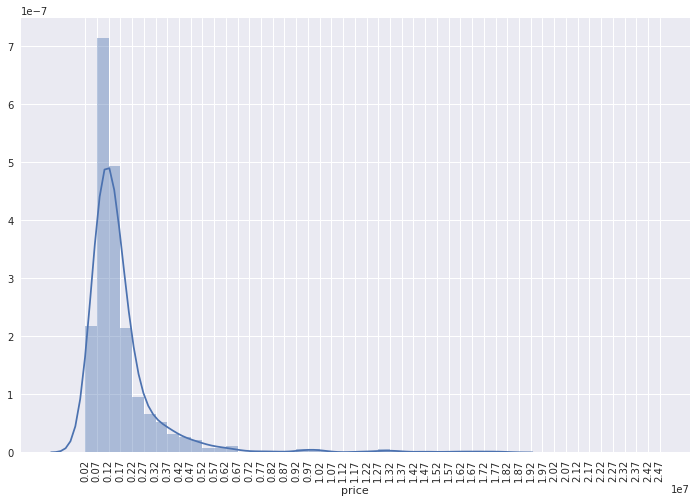

In [147]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(df: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(df.price, bins=bins)

bins = range(int(df.price.min()), int(df.price.max()), 500000)
plot_prices(df.dropna(), bins)

### Definitely a skewed distribution, looks as if we have a few outliers at the higher range of the prices.  
### We can quantify how "non-normal" our distribution is by calculating:  
* `Skewness` - A measure of the symmetry (or lack thereof) of a distribution
* `Kurtosis` - Whether distrubition is "heavy-tailed" or "light-tailed" or in other words: how "sharp" the peak is.

In [148]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 4.360084
Kurtosis: 26.174060


## Plot with outliers removed

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness (outliers removed): 1.927261
Kurtosis (outliers removed): 3.995836


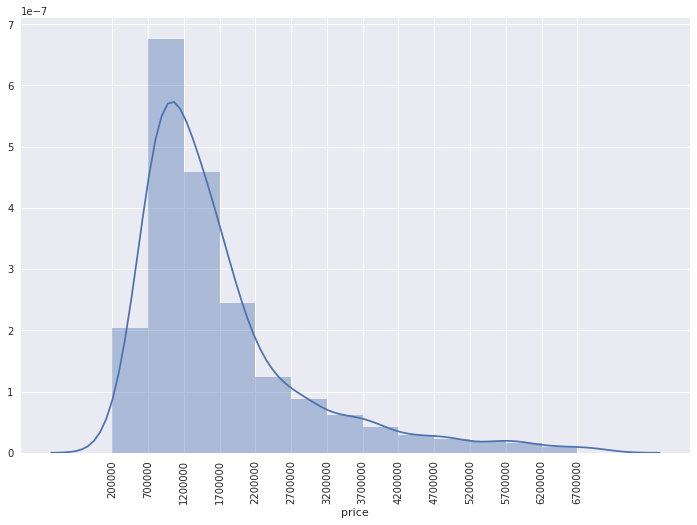

In [149]:
df_no_outliers = df[df.price < 7e6]
bins = range(int(df_no_outliers.price.min()),int(df_no_outliers.price.max()),500000)
plot_prices(df_no_outliers, bins)
print("Skewness (outliers removed): %f" % df_no_outliers['price'].skew())
print("Kurtosis (outliers removed): %f" % df_no_outliers['price'].kurt())

### Removing the outliers improved our skewness and kurtosis values.
We will remember this when cleaning the data for our model. Machine learning models work best with normally distributed data. Outliers may affect model performance.

## Plot missing values.
Recall that there were some columns which are incomplete. Plot a bar graph describing this:

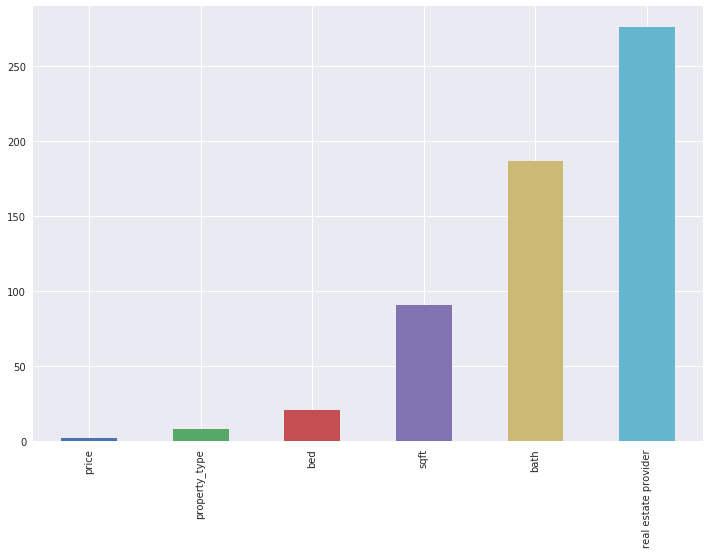

In [150]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Variables that are missing values can either be removed from the dataset or have their missing values replaced (perhaps with 0 or the mean of the column). Remember this for data cleaning.

## Visualize the house prices w.r.t. location with a slippy map  
We have some location information in the `address` column. We'll use geocoding to convert the string address to Lat Long.  

In [151]:
import time
import random
from IPython.display import clear_output
from geopy.geocoders import Nominatim
NUM_RETRIES = 3 # number of retries for request
def address_to_latlng(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Fetch LatLng coords using Nominatim
    
    Args:
        dataframe: pd.DataFrame containing `address` and `city` columns
    Returns:
        pd.DataFrame: dataframe with `latlng` column added
        
    """
    dataframe = dataframe.copy()
    geocoder = Nominatim()
    latlngs = []
    print("fetching LatLng coords...")
    for address, city in zip(dataframe.address, dataframe.city):
        time.sleep(int(random.randint(0,6)/3)) # try not to get your ip blacklisted by Nominatim
        clear_output(wait=True)
        location = None
        for i in range(NUM_RETRIES):
            try:
                location = geocoder.geocode(f'{address} {city}')
                break
            except Exception as e:
                print(f"Error: {e}")
        if location:
            latlngs.append((location.latitude, location.longitude))
        else:
            latlngs.append(None)
        print(f'{len(latlngs)+1}/{len(dataframe)} complete...')
    dataframe['latlng'] = latlngs
    return dataframe

The above function `generate_latlng()` takes a while to run since we call a web service `Nominatim` to perform the address --> latlng lookup.  
You can choose to load from a pre-processed csv file `data_w_latlng.csv` which is provided (Recommended)

In [153]:
# uncomment below to fetch LatLng coords from Nominatim (takes a while ~30mins)
################################################
# df = address_to_latlng(df)
# df.to_csv('data_w_latlng.csv', index=False)
################################################
# load pre-fetched latlng data
df = pd.read_csv(os.path.join(data_dir, 'data_w_latlng.csv'))
len(df)

1262

In [154]:
df.head(10)

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
0,New Construction,288 Pacific Ave # 67UQRR,San Francisco,CA,94111,NaN,"-- bds , -- ba , -- sqft",NaN,https://www.zillow.com/community/288-pacific/2...,NaN,NaN,NaN,new,NaN
1,Condo For Sale,733 Front St UNIT 606,SAN FRANCISCO,CA,94111,1195000.0,"1 bd , 1 ba , 920 sqft",Climb Real Estate,https://www.zillow.com/homedetails/733-Front-S...,1.0,1.0,920.0,condo,NaN
2,Condo For Sale,101 Lombard St APT 401W,SAN FRANCISCO,CA,94111,1425000.0,"2 bds , 2 ba , 1,238 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/101-Lombard...,2.0,2.0,1238.0,condo,NaN
3,Condo For Sale,111 Chestnut St UNIT 109,SAN FRANCISCO,CA,94111,1600000.0,"2 bds , 2 ba , 1,925 sqft",CENTURY 21 Real Estate Alliance,https://www.zillow.com/homedetails/111-Chestnu...,2.0,2.0,1925.0,condo,NaN
4,Lot/Land For Sale,1235 Sansome St,San Francisco,CA,94111,998000.0,"6,882 sqft lot",NaN,https://www.zillow.com/homedetails/1235-Sansom...,NaN,NaN,6882.0,lot,"(37.8015226190476, -122.402951)"
5,Condo For Sale,240 Lombard St APT 625,SAN FRANCISCO,CA,94111,678888.0,"1 bd , 1 ba , 580 sqft",Sotheby's International Realty - San Francisco...,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,580.0,condo,NaN
6,Condo For Sale,240 Lombard St APT 739,SAN FRANCISCO,CA,94111,777000.0,"1 bd , 1 ba , 840 sqft",CENTURY 21 Real Estate Alliance,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,840.0,condo,NaN
7,Condo For Sale,240 Lombard St APT 437,SAN FRANCISCO,CA,94111,619900.0,"1 bd , 1 ba , 566 sqft",SimpleListing.com,https://www.zillow.com/homedetails/240-Lombard...,1.0,1.0,566.0,condo,NaN
8,House For Sale,62 Miramar Ave,SAN FRANCISCO,CA,94112,995000.0,"3 bds , 2 ba , 1,500 sqft",Zephyr Real Estate,https://www.zillow.com/homedetails/62-Miramar-...,3.0,2.0,1500.0,house,"(37.7193235, -122.458068125)"
9,House For Sale,21 Agnon Ave,SAN FRANCISCO,CA,94112,1495000.0,"3 bds , 2 ba , 2,235 sqft",Sotheby's International Realty - San Francisco...,https://www.zillow.com/homedetails/21-Agnon-Av...,3.0,2.0,2235.0,house,"(37.7348416093506, -122.422086939437)"


We use `folium` to render the slippy map in the notebook.  
Note that there are hundreds of houses to be displayed and this requires a fair bit of RAM. If your browser crashes you can adjust the amount to be displayed by changing the variable `display_max`.

In [155]:
def draw_houses_on_map(dataframe: pd.DataFrame):
    dataframe = dataframe.copy()
    # create a folium map object centered in SF
    m = folium.Map(location=(37.7, -122.4))
    # create a colormap of the prices (we limit prices between 5e5 and 10e6)
    colors = ['gray', 'green','blue','red','orange', 'yellow']
    min_price, max_price = 5e5, 6e6
    colormap = StepColormap(colors=colors,vmin=min_price, vmax=max_price, caption='price')
    m.add_child(colormap)
    # amount of points to render on the map. WARNING: significant RAM required to plot all points and may crash your browser 
    display_max = len(dataframe) # plot all
    # display_max = 100 # uncomment and adjust this number if needed
    displayed = 0
    for i, latlng in zip(dataframe.index, dataframe['latlng']):
        price = dataframe.loc[i, 'price']
        if latlng is not None:
            if isinstance(latlng, str):
                lat, lng = latlng.replace('(','').replace(')','').split(',')
                latlng = (float(lat), float(lng))
            if not isinstance(latlng, tuple):
                continue
            style = {'fillColor': colormap(price),
                    'color' : colormap(price)}
            p = geojson.Point(coordinates=(latlng[1], latlng[0]), style=style)
            # build an HTML string to be displayed if we click a marker.
            html_info = '<li>Price: ${}</li><li>Property Type: {}</li>'.format(dataframe.loc[i, 'price'], dataframe.loc[i, 'property_type'])
            m.add_child(folium.Marker(location=latlng, icon=folium.Icon(color='black', icon_color=colormap(price)), popup=folium.Popup(html=html_info)))
            displayed += 1
            if displayed > display_max:
                break
    return m
draw_houses_on_map(df)

We can observe some patterns w.r.t. location.  
Seems the more expensive homes are Central and North and the "lower" (finger quotes) priced homes on the outside

## Next, let's see how some of the variables interact with the list price.  
Since `price` is our target variable (the variable we are trying to predict), it is useful visualize how each variable relates to `price`. 

### sqft
Total square footage

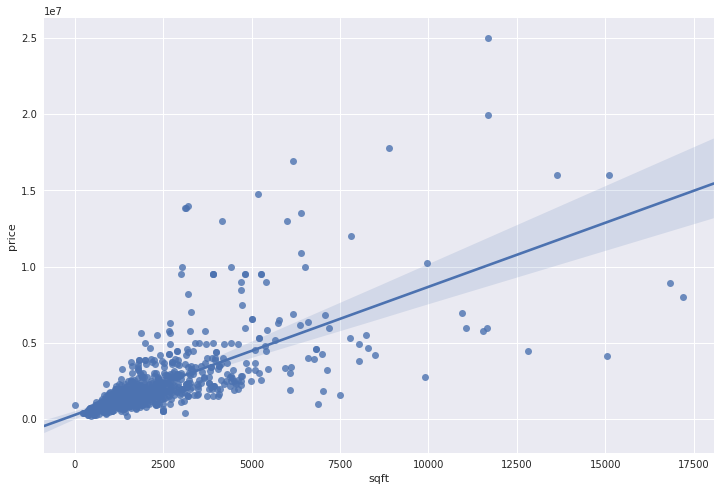

In [156]:
# sqft/saleprice
var = 'sqft'
sns.regplot(df[var], df['price'], )

The relationship looks linear with some spreading as sqft increases. We can also see there are some houses with almost zero square feet! Let's investigate why:  
  
Note on `pandas.DataFrame` indexing:  
* `df['sqft'] < condition` gives us a "truth array" where True values match the condition and False otherwise. If we index the original DataFrame with this truth array we get a filtered result

In [157]:
# filter the DataFrame with nearly zero sqft
df[df['sqft'] < 10].head()

,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type,latlng
1085,Condo For Sale,338 Spear St UNIT 15G,San Francisco,CA,94105,949000.0,"1 bd , 1 ba , 1 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/338-Spear-S...,1.0,1.0,1.0,condo,NaN


Looks like we have some bad data from the web scraping. We will remember to remove these when we get to our data cleaning notebook

### bed
Number of bedrooms

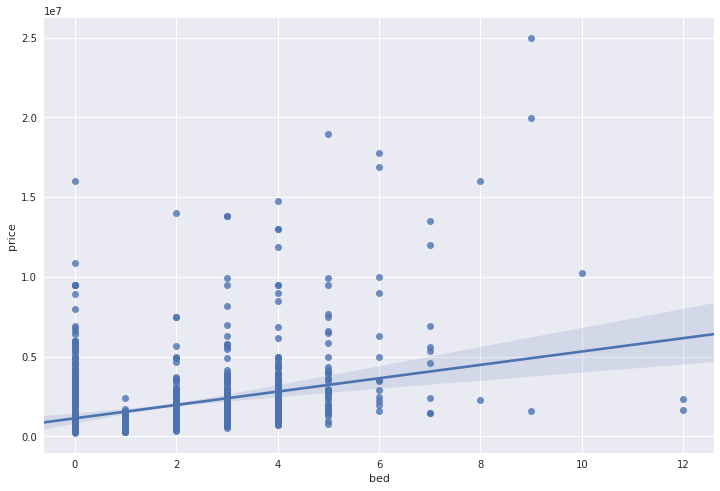

In [158]:
var = 'bed'
sns.regplot(df[var], df['price'], )

We observe a bit of a positive correlation between price and number of beds

### bath
Number of bathrooms

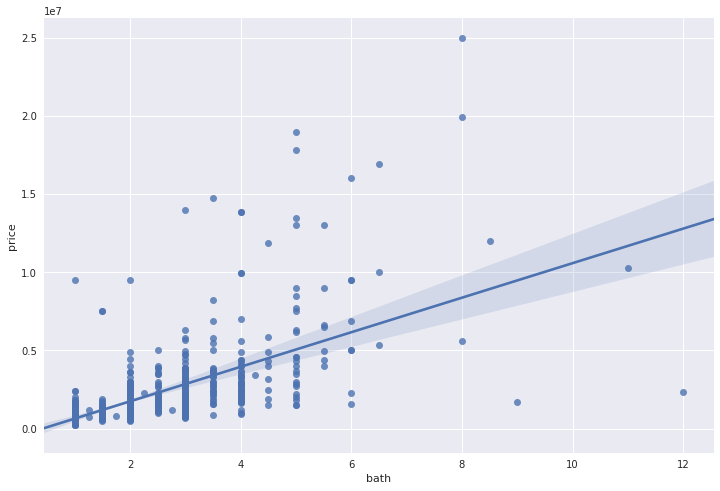

In [159]:
var = 'bath'
sns.regplot(df[var], df['price'], )

Positive correlation between number of baths and price

## Generate a correlation matrix

A correlation matrix will graphically show us which variables are most correlated to our target variable `price`.  
A positive correlation (w.r.t. price) means as the variable increases, the price increases

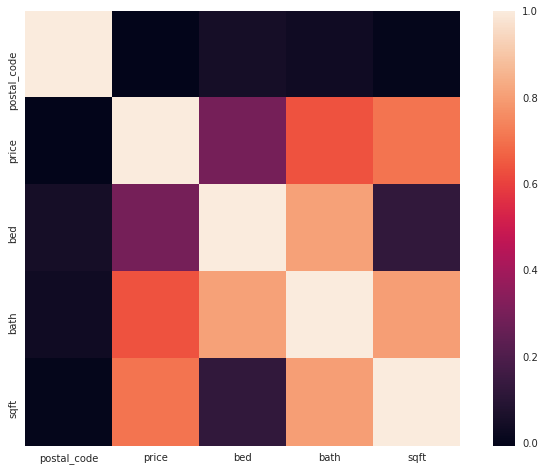

In [160]:
corrmat = df.corr()
sns.heatmap(corrmat, vmax=1, square=True);

Observe the `price` across a row or column to get an idea which variables are most likely to correlate to price.

## Categorical Variables.  
So far we have only dealt with numeric variables however there are several non-numerical (**Categorical**) variables to be investigated as well:  
  
Categorical variables are ones which provide information but are not quantified numerically. For instance, the `postal_code` variable gives us information about which neighbourhood the house is located. We found from our map plot that this data may be useful for predicting `price`.  
  
In order to use these categorical variables in our model, we encode them into a numerical representation called a [Dummy Variable]. We cover Dummy Variables in a later notebook.
[Dummy Variable]: https://en.wikipedia.org/wiki/Dummy_variable_(statistics)

In [161]:
print(df.columns)

Index(['title', 'address', 'city', 'state', 'postal_code', 'price',
       'facts and features', 'real estate provider', 'url', 'bed', 'bath',
       'sqft', 'property_type', 'latlng'],
      dtype='object')


Let's choose `property_type`, and `postal_code` to investigate.  
We can use the `unique()` function on the categorical columns to see the different categories.

In [162]:
print(df['postal_code'].value_counts())
print(df['property_type'].value_counts())

94109    83
94115    74
94110    72
94114    72
94107    71
94131    64
94112    63
94133    59
94121    59
94118    59
94105    58
94103    56
94123    55
94122    54
94124    53
94117    53
94116    42
94127    37
94108    32
94134    30
94158    28
94102    27
94132    18
94104    18
94111    16
94501     2
94044     1
94014     1
94005     1
94706     1
94608     1
94607     1
94530     1
Name: postal_code, dtype: int64
condo          559
house          384
apartment      186
new             68
coming          23
lot             13
auction          9
coop             7
foreclosure      4
townhouse        1
Name: property_type, dtype: int64


There are some variables with only a single value, let's get rid of that data.

In [163]:
postal_codes = [
'94530',
'94014',
'94608',
'94607',
'94005',
'94706',
'94501'
]
for postal_code in postal_codes:
    df = df[df.postal_code != int(postal_code)]
property_types = ['townhouse', 'foreclosure']
for property_type in property_types:
    df = df[df.property_type != property_type]
print(df['postal_code'].value_counts())
print(df['property_type'].value_counts())

94109    83
94115    74
94114    72
94110    71
94107    71
94131    64
94112    62
94121    59
94118    59
94133    59
94105    58
94103    56
94123    55
94122    53
94117    53
94124    53
94116    41
94127    37
94108    32
94134    29
94158    28
94102    27
94104    18
94132    18
94111    16
94044     1
Name: postal_code, dtype: int64
condo        558
house        380
apartment    186
new           66
coming        22
lot           13
auction        9
coop           7
Name: property_type, dtype: int64


Visualize these categories as box plots.  
We use the `pandas.melt()` function to flatten our variables into a single column so we can plot.  
The result of using `melt()` is most easily understood by displaying the result.

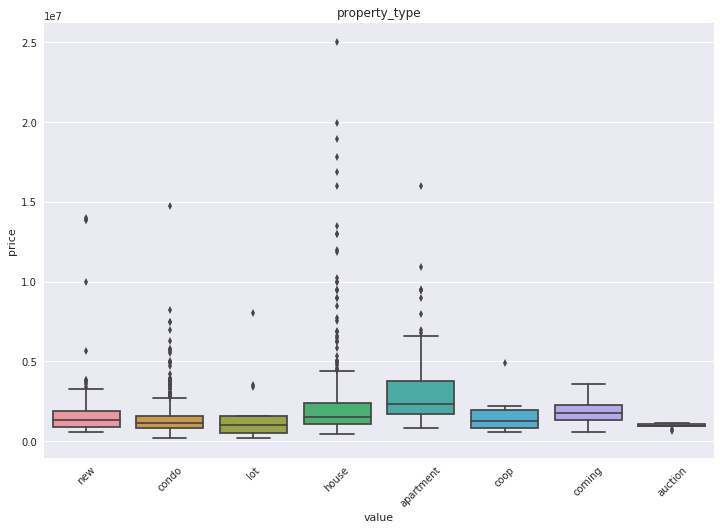

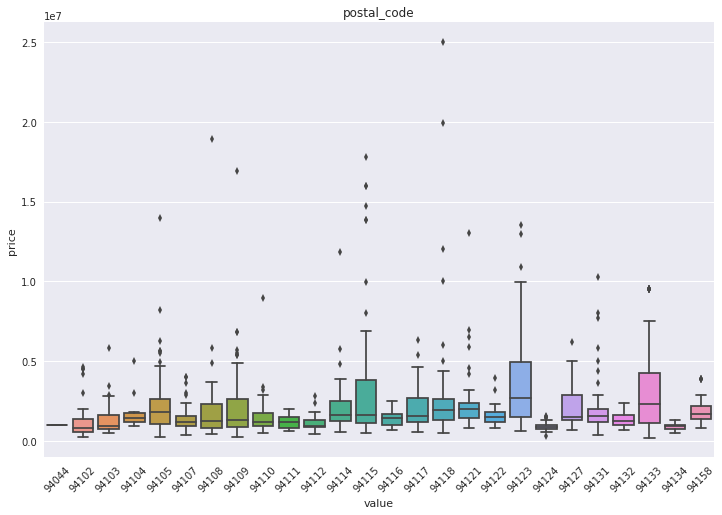

In [164]:
vars_to_analyze = ['property_type', 'postal_code']
df_melt = pd.melt(df, id_vars=['price'], value_vars=vars_to_analyze)
for var in vars_to_analyze:
    df_var = df_melt[df_melt['variable'] == var]
    sns.boxplot(x=df_var['value'], y=df_var['price'])
    x=plt.xticks(rotation=45)
    plt.title(var)
    plt.show()

In [165]:
# uncomment to see the effects of melt()
# df_melt.head(20)
# df.head(20)

## Analysis of variance (ANOVA)
We use ANOVA to explore how much variance occurs **between** groups (ie. *[price vs property_type]* vs *[price vs postal_code]*) versus how much variance occurs **within** each group (ie *[price vs sub_area]* alone).  
In the end this tells us is how useful it will be to group `price` into these 4 groups (and if including each variable in our model is useful to us).  
Here's a quick YouTube video that may better explain ANOVA:  

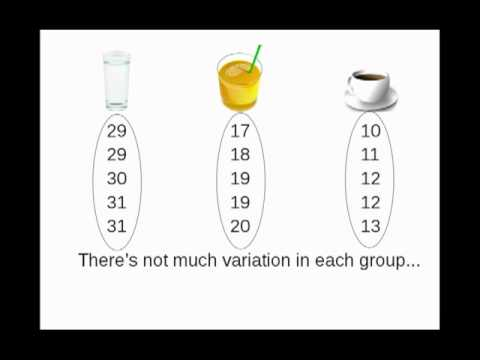

In [166]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='ITf4vHhyGpc')

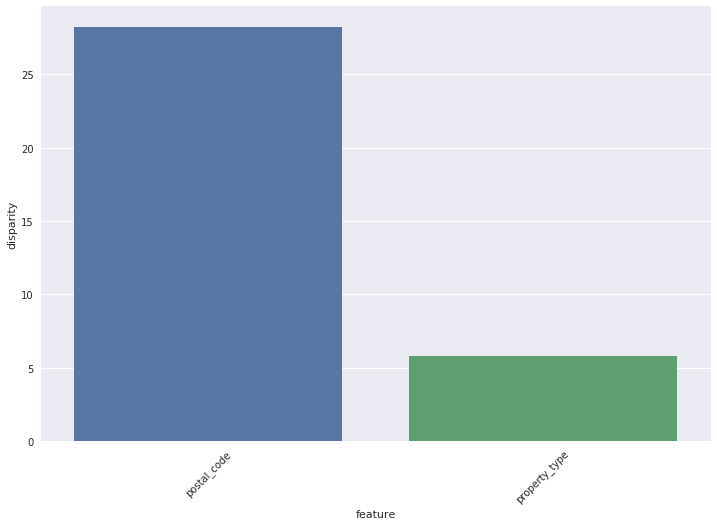

In [167]:
def anova(df):
    anv = pd.DataFrame()
    anv['feature'] = vars_to_analyze
    pvals = []
#     import pdb; pdb.set_trace()
    for c in vars_to_analyze:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['price'].values
            samples.append(s)
        try:
            pval = stats.f_oneway(*samples)[1]
        except Exception as e:
            pval=None
            print(e)
        finally:
            pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df.dropna())
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=45)

This gives us a rough estimate of effect each variable will have on our model.

# Save our DataFrame to .csv

In [168]:
df.to_csv(os.path.join(data_dir,'data.csv'), index=False)

## Hopefully the EDA has improved our intuition about the dataset. Now we can move onto data cleaning!